# 1. Dataset 불러오기

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 2. Dataset 확인하기

In [ ]:
def imageshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

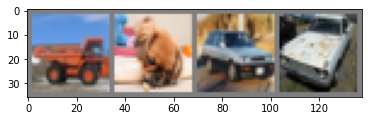

truck dog   car   car  


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imageshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# VGG16 model 생성
layer 1`~`3: 16 * 16 * 64 <br>
layer 4`~`6: 8 * 8 * 128 <br>
layer 7`~`10: 4 * 4 * 256 <br>
layer 11`~`14: 2 * 2 * 512 <br>


In [ ]:
cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

In [ ]:
def make_layer(config):
    layers = []
    in_planes = 3
    for value in config:
        if value == 'M':
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            layers.append(nn.Conv2d(in_planes, value, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_planes = value
    return nn.Sequential(*layers)

In [ ]:
class VGG(nn.Module):
    def __init__(self, config):
        super(VGG, self).__init__()
        self.features = make_layer(config)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10)  
        ) 
        
    def forward(self, x):
        out = self.features(x)
        out = torch.flatten(out,1)
        out = self.classifier(out)
        return out

In [ ]:
model = VGG(cfg)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform(m.weight)

model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
learning_rate = 0.05
num_epoch = 10
model_name = 'model.pth'

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

train_loss = 0
valid_loss = 0
correct = 0
total_cnt = 0
best_acc = 0

In [ ]:
def lr_scheduler(optimizer, epoch):
    lr = learning_rate
    if epoch >= 30:
        lr /= 2
    if epoch >= 60:
        lr /= 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
for epoch in range(num_epoch):
    print(f"====== { epoch+1} epoch of { num_epoch } ======")
    model.train()
    lr_scheduler(optimizer, epoch)
    train_loss = 0
    valid_loss = 0
    correct = 0
    total_cnt = 0
    # Train Phase
    for step, batch in enumerate(trainloader):
        #  input and target
        batch[0], batch[1] = batch[0], batch[1]
        optimizer.zero_grad()
        
        logits = model(batch[0])
        loss = loss_fn(logits, batch[1])
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        _, predict = logits.max(1)
        
        total_cnt += batch[1].size(0)
        correct +=  predict.eq(batch[1]).sum().item()
        
        if step % 100 == 0 and step != 0:
            print(f"\n====== { step } Step of { len(trainloader) } ======")
            print(f"Train Acc : { correct / total_cnt }")
            print(f"Train Loss : { loss.item() / batch[1].size(0) }")
            
    correct = 0
    total_cnt = 0

====== 1 epoch of 10 ======

====== 100 Step of 12500 ======
Train Acc : 0.07425742574257425
Train Loss : nan

====== 200 Step of 12500 ======
Train Acc : 0.09701492537313433
Train Loss : nan

====== 300 Step of 12500 ======
Train Acc : 0.09966777408637874
Train Loss : nan

====== 400 Step of 12500 ======
Train Acc : 0.10162094763092269
Train Loss : nan

====== 500 Step of 12500 ======
Train Acc : 0.10179640718562874
Train Loss : nan

====== 600 Step of 12500 ======
Train Acc : 0.09858569051580698
Train Loss : nan

====== 700 Step of 12500 ======
Train Acc : 0.09950071326676177
Train Loss : nan

====== 800 Step of 12500 ======
Train Acc : 0.10268414481897628
Train Loss : nan

====== 900 Step of 12500 ======
Train Acc : 0.103496115427303
Train Loss : nan

====== 1000 Step of 12500 ======
Train Acc : 0.1038961038961039
Train Loss : nan

====== 1100 Step of 12500 ======
Train Acc : 0.1044504995458674
Train Loss : nan

====== 1200 Step of 12500 ======
Train Acc : 0.10699417152373022
Train 

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
        model.eval()
        for step, batch in enumerate(testloader):
            # input and target
            batch[0], batch[1] = batch[0], batch[1]
            total_cnt += batch[1].size(0)
            logits = model(batch[0])
            valid_loss += loss_fn(logits, batch[1])
            _, predict = logits.max(1)
            correct += predict.eq(batch[1]).sum().item()
        valid_acc = correct / total_cnt
        print(f"\nValid Acc : { valid_acc }")    
        print(f"Valid Loss : { valid_loss / total_cnt }")

        if(valid_acc > best_acc):
            best_acc = valid_acc
            torch.save(model, model_name)
            print("Model Saved!")

# ResNet18

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
#from torch.utils import random_split # train data와 validation data 나누기 위해

train_transform = transforms.Compose(
    [ transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(), # C*H*W
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 세 채널에 대한 평균과 표준편차 [-1, 1]

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

val_ratio = 0.2
# train_dataset, val_dataset = random_split(dataset, [int((1-val_ratio) * len(dataset)), int(val_ratio * len(dataset))] #validation data

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2) #pin_memory=True
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2) #pin_memory=True
#val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=2) #pin_memory=True

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


이미지 보기

In [ ]:
def denormalize(images, means, std_devs):
    # image *std_dev + mean
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    std_devs = torch.tensor(std_devs).reshape(1, 3, 1, 1)
    return images * std_devs + means

def show_batch(dl):
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        #images = denormalize(images, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ax.imshow(make_grid(images, 10).permute(1,2,0)) #H*W*C
        break

show_batch(train_loader)

NameError: ignored

use an instance of this class the same way i was using the imported data loader



In [ ]:
"""def get_default_device():
  return torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")

def to_device(entity, device):
  if isinstance(entity, (list, tuple)):
    return [to_device(elem, device) for elem in entity]
  return entity.to(device, non_blocking=True)

class DeviceDataLoader():
  #wrapper around dataloaders to transfer batches to specified devices#
  def __init__(self, dataloader, device):
    self.dl = dataloader
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  def __len(self):
    return len(self.dl)

device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
#val_dl = DeviceDataLoader(val_dl, device) """


'def get_default_device():\n  return torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")\n\ndef to_device(entity, device):\n  if isinstance(entity, (list, tuple)):\n    return [to_device(elem, device) for elem in entity]\n  return entity.to(device, non_blocking=True)\n\nclass DeviceDataLoader():\n  #wrapper around dataloaders to transfer batches to specified devices#\n  def __init__(self, dataloader, device):\n    self.dl = dataloader\n    self.device = device\n\n  def __iter__(self):\n    for b in self.dl:\n      yield to_device(b, self.device)\n  def __len(self):\n    return len(self.dl)\n\ndevice = get_default_device()\ntrain_loader = DeviceDataLoader(train_loader, device)\ntest_loader = DeviceDataLoader(test_loader, device)\n#val_dl = DeviceDataLoader(val_dl, device) '

In [ ]:
"""class IdentityPadding(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(IdentityPadding, self).__init__()
        #with kernel_size=1, max pooling is equivalent to identity mapping with stride
        self.identity = nn.MaxPool2d(1,stride=stride)
        self.add_channels = out_channels - in_channels
        
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.add_channels))
        out = self.identity(out)
        return out"""

class ResidualBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(ResidualBlock, self).__init__()

        #3x3 커널(필터) 사용. stride 값은 dimension 바꿀 때 사용(W, H 줄일 때 stride=2 설정
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu1 = nn.ReLU(inplace=True)

        #3x3 커널(필터) 사용
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_planes)
      
        self.shortcut = nn.Sequential() # identity
        if stride != 1  or in_planes != out_planes: # dimension을 맞춰주기 위해 stride값 조절해서 skip connection 할 수 있게
		        self.shortcut = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                                          nn.BatchNorm2d(out_planes))
        self.relu2 = nn.ReLU(inplace=True)
      
    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # identity mapping. skip connection
        out = self.relu2(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10): # block 개수 입력받음
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        # 64개 3x3 filters 사용
        # image-net 학습할 때 사용했던 capacity 큰 구조를 따르면서 입력단의 크기만 cifar-10에 맞게
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # 논문과 동일하게 filter 개수 설정 (64, 128, 256, 512)
        # residualblock 이어붙임
        # filter 개수 증가할 때마다 W, H 감소할 수 있도록 함 (stride=2)
        # Residual block(basic block) 당 conv layer가 2개. 그걸 2번 연결 => layer1은 4개의 conv layer, layer1~4은 총 16개의 conv layer
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes) # 마지막에 fully-connected layer

    def make_layer(self, block, out_planes, num_blocks, stride): # layer 구성
        strides = [stride] + [1] * (num_blocks - 1) # 첫 번째 conv 연산에 의해서만 W, H가 줄어들 수 있게. 그 다음 이어붙이는 것들은 같은 W H 유지할 수 있도록 stride=1
        layers = []

        # 다음 layer를 위해 확장된 채널 수로 업데이트
        for stride in strides:
            layers.append(block(self.in_planes, out_planes, stride))
            self.in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


device = 'cuda'

ResNet18 = ResNet(block=ResidualBlock, num_blocks=[2,2,2,2]) # ResidualBlock이 두 번씩 사용됨
ResNet34 = ResNet(block=ResidualBlock, num_blocks=[3,4,6,3]) # ResidualBlock이 3, 4, 6, 3번씩 사용됨